Here you may get familiar with PU learning, play with mixtures of laplace and normal distributions, test DEDPUL and other methods.

The notebook is based on the paper "DEDPUL: Difference-of-Estimated-Densities-based Positive-Unlabeled Learning". 

NOTE that in the original paper proportions and posteriors of Positive class are presented and estimated, while methods in this notebook by default estimate those for Negative class. To convert, just substract the estimates from 1.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace
import random

from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, brier_score_loss, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
from IPython import display

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: F

# What is PU learning?

Positive-Unlabeled (PU) Classification is a problem of semi-supervised learning on the data that is corrupted in a specific way. Unlike supervised binary classification, PU classification does not require labeled samples from both classes for training. Instead, two samples are required: a labeled sample from Positive (P) class, and an Unlabeled (U) sample with mixed data from both Positive (P) and Negative (N) classes with generally unknown mixing proportions. The objectives are: (i) to estimate the proportions of P and N in U and (ii) to classify it, i.e. to assign probability of being P rather than N for each instance in U. The first problem is reffered to as Mixture Proportions Estimation; the second - as PU Classification.

Several methods that solve these problems are highlighted in this notebook.

# Data

In [2]:
# specify distributions to sample data from.

# mode = 'normal'
mode ='laplace'

In [3]:
# feel free to play with parameters of distributions;
# initially we recommend to stick to cases of s1=s2

# centers and standard deviations of P and N distributions
mu1 = 0
s1 = 1
mu2 = 4
s2 = 1

# alpha is proportion of N in U; (1 - alpha) is proportion of P in U; these will be unknown for methods below;
# note that not alpha but alpha^* (computed below) is the proportion that the methods are supposed to identify 
# (find out why in the paper)
alpha = 0.75

if mode == 'normal':
    p1 = lambda x: norm.pdf(x, mu1, s1)
    p2 = lambda x: norm.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha
elif mode == 'laplace':
    p1 = lambda x: laplace.pdf(x, mu1, s1)
    p2 = lambda x: laplace.pdf(x, mu2, s2)
    pm = lambda x: p1(x) * (1 - alpha) + p2(x) * alpha

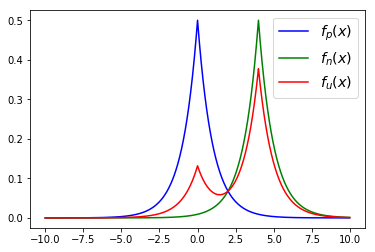

In [4]:
# These are the distributions.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot([x/100 for x in range(-1000, 1000)], [pm(x/100) for x in range(-1000, 1000)], 'r')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='r')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f_u(x)$'),
          fontsize='x-large')

Lets generate samples from the Positive and the Unlabeled distributions $f_p(x)$ and $f_u(x)$. Remember, we don't have Negative data from $f_n(x)$.

In [5]:
if mode == 'normal':
    sampler = np.random.normal
elif mode == 'laplace':
    sampler = np.random.laplace

In [6]:
mix_size =10000
pos_size = 1000

mix_data_test = np.append(sampler(mu1, s1, int(mix_size * (1 - alpha))), 
                          sampler(mu2, s2, int(mix_size * alpha)))
pos_data_test = sampler(mu1, s1, int(pos_size))

data_test = np.append(mix_data_test, pos_data_test).reshape((-1, 1))
target_test = np.append(np.array([1] * mix_size), np.array([0] * pos_size))
target_test_true = np.append(np.array([0] * int(mix_size * (1 - alpha))), np.array([1] * int(mix_size * alpha)))
target_test_true = np.append(target_test_true, np.array([2] * pos_size))

mix_data_test = mix_data_test.reshape([-1, 1])
pos_data_test = pos_data_test.reshape([-1, 1])

data_test = np.concatenate((data_test, target_test.reshape(-1, 1), target_test_true.reshape(-1, 1)), axis=1)
np.random.shuffle(data_test)
target_test = data_test[:, 1]
target_test_true = data_test[:, 2]
data_test = data_test[:, 0].reshape(-1, 1)

In [7]:
# here we may estimate ground truth alpha^* for limited number of cases: 
# laplace and normal distributions where either mean or std coincide.
# alpha^* is the desired proportion that the methods are supposed to identify.

cons_alpha = estimate_cons_alpha(mu2 - mu1, s2 / s1, alpha, mode)
print('alpha* =', cons_alpha)

alpha* = 0.7362632708334493


Below several methods are applied to solve MPE and PU Classification

# DEDPUL

The short way:

In [13]:
test_alpha, poster = estimate_poster_cv(data_test, target_test, estimator='dedpul', alpha=None,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={},
                                         estimate_preds_cv_options={'bn': False, 'l2': 1e-4,
                                             'cv': 5, 'n_networks': 1, 'lr': 1e-3, 'hid_dim': 16, 'n_hid_layers': 0,
                                         },
                                         train_nn_options={
                                             'n_epochs': 200, 'batch_size': 64,
                                             'n_batches': None, 'n_early_stop': 10, 'disp': True,
                                        }
                                       )

print('alpha:', test_alpha, '\nerror:', abs(test_alpha - cons_alpha))

epoch 0 , train_loss= 0.70716 , test_loss= 0.68696
epoch 1 , train_loss= 0.67501 , test_loss= 0.65621
epoch 2 , train_loss= 0.64491 , test_loss= 0.63082
epoch 3 , train_loss= 0.61532 , test_loss= 0.60941
epoch 4 , train_loss= 0.60946 , test_loss= 0.59223
epoch 5 , train_loss= 0.57793 , test_loss= 0.57724
epoch 6 , train_loss= 0.57962 , test_loss= 0.56466
epoch 7 , train_loss= 0.5704 , test_loss= 0.55435
epoch 8 , train_loss= 0.55962 , test_loss= 0.54533
epoch 9 , train_loss= 0.5313 , test_loss= 0.53697
epoch 10 , train_loss= 0.54736 , test_loss= 0.52956
epoch 11 , train_loss= 0.5197 , test_loss= 0.52281
epoch 12 , train_loss= 0.52391 , test_loss= 0.51699
epoch 13 , train_loss= 0.53124 , test_loss= 0.51185
epoch 14 , train_loss= 0.51989 , test_loss= 0.50728
epoch 15 , train_loss= 0.50304 , test_loss= 0.50275
epoch 16 , train_loss= 0.49941 , test_loss= 0.4987
epoch 17 , train_loss= 0.50656 , test_loss= 0.49501
epoch 18 , train_loss= 0.50731 , test_loss= 0.49168
epoch 19 , train_loss= 0.4

epoch 23 , train_loss= 0.42237 , test_loss= 0.44266
epoch 24 , train_loss= 0.44851 , test_loss= 0.44061
epoch 25 , train_loss= 0.46139 , test_loss= 0.43902
epoch 26 , train_loss= 0.44501 , test_loss= 0.43775
epoch 27 , train_loss= 0.45984 , test_loss= 0.43662
epoch 28 , train_loss= 0.43775 , test_loss= 0.43552
epoch 29 , train_loss= 0.44529 , test_loss= 0.43434
epoch 30 , train_loss= 0.44653 , test_loss= 0.43348
epoch 31 , train_loss= 0.41092 , test_loss= 0.43234
epoch 32 , train_loss= 0.40735 , test_loss= 0.43125
epoch 33 , train_loss= 0.4332 , test_loss= 0.43039
epoch 34 , train_loss= 0.44949 , test_loss= 0.42964
epoch 35 , train_loss= 0.4319 , test_loss= 0.42927
epoch 36 , train_loss= 0.42843 , test_loss= 0.42879
epoch 37 , train_loss= 0.4368 , test_loss= 0.42838
epoch 38 , train_loss= 0.43059 , test_loss= 0.4279
epoch 39 , train_loss= 0.43675 , test_loss= 0.42749
epoch 40 , train_loss= 0.41976 , test_loss= 0.42703
epoch 41 , train_loss= 0.40675 , test_loss= 0.42636
epoch 42 , train

epoch 80 , train_loss= 0.42456 , test_loss= 0.42546
epoch 81 , train_loss= 0.41161 , test_loss= 0.42518
epoch 82 , train_loss= 0.42574 , test_loss= 0.42511
epoch 83 , train_loss= 0.42256 , test_loss= 0.42517
epoch 84 , train_loss= 0.41694 , test_loss= 0.42513
epoch 85 , train_loss= 0.42425 , test_loss= 0.42543
epoch 86 , train_loss= 0.4116 , test_loss= 0.42545
epoch 87 , train_loss= 0.43717 , test_loss= 0.42537
epoch 88 , train_loss= 0.4364 , test_loss= 0.42543
epoch 89 , train_loss= 0.42037 , test_loss= 0.42518
epoch 90 , train_loss= 0.43404 , test_loss= 0.42488
epoch 91 , train_loss= 0.40973 , test_loss= 0.42443
epoch 92 , train_loss= 0.43223 , test_loss= 0.42425
epoch 93 , train_loss= 0.4512 , test_loss= 0.42426
epoch 94 , train_loss= 0.41209 , test_loss= 0.42425
epoch 95 , train_loss= 0.43682 , test_loss= 0.42434
epoch 96 , train_loss= 0.40485 , test_loss= 0.42446
epoch 97 , train_loss= 0.41421 , test_loss= 0.42414
epoch 98 , train_loss= 0.45097 , test_loss= 0.42406
epoch 99 , trai

epoch 96 , train_loss= 0.42772 , test_loss= 0.41894
epoch 97 , train_loss= 0.43183 , test_loss= 0.41895
epoch 98 , train_loss= 0.43308 , test_loss= 0.41893
epoch 99 , train_loss= 0.44321 , test_loss= 0.41892
epoch 100 , train_loss= 0.43672 , test_loss= 0.41866
epoch 101 , train_loss= 0.43062 , test_loss= 0.41868
epoch 102 , train_loss= 0.42998 , test_loss= 0.41855
epoch 103 , train_loss= 0.42302 , test_loss= 0.41827
epoch 0 , train_loss= 0.6508 , test_loss= 0.62916
epoch 1 , train_loss= 0.60958 , test_loss= 0.59068
epoch 2 , train_loss= 0.57228 , test_loss= 0.55989
epoch 3 , train_loss= 0.54909 , test_loss= 0.53571
epoch 4 , train_loss= 0.54067 , test_loss= 0.51807
epoch 5 , train_loss= 0.52056 , test_loss= 0.50415
epoch 6 , train_loss= 0.5049 , test_loss= 0.49332
epoch 7 , train_loss= 0.49501 , test_loss= 0.48444
epoch 8 , train_loss= 0.47871 , test_loss= 0.47702
epoch 9 , train_loss= 0.47431 , test_loss= 0.47111
epoch 10 , train_loss= 0.48062 , test_loss= 0.46623
epoch 11 , train_los

The short-but-a-bit-longer way:

In [9]:
# estimate y(x), the predictions of NTC

preds = estimate_preds_cv(data_test, target_test, cv=5, n_networks=1, lr=1e-3, hid_dim=16, n_hid_layers=0, l2=1e-4,
                          bn=False,
                          train_nn_options={'n_epochs': 200, 'batch_size': 64,
                                            'n_batches': None, 'n_early_stop': 10, 'disp': True})

print('ac', accuracy_score(target_test, preds.round()))
print('roc', roc_auc_score(target_test, preds))

epoch 0 , train_loss= 0.88167 , test_loss= 0.84965
epoch 1 , train_loss= 0.81522 , test_loss= 0.78609
epoch 2 , train_loss= 0.75927 , test_loss= 0.73254
epoch 3 , train_loss= 0.7119 , test_loss= 0.68877
epoch 4 , train_loss= 0.6736 , test_loss= 0.65243
epoch 5 , train_loss= 0.63556 , test_loss= 0.62251
epoch 6 , train_loss= 0.60703 , test_loss= 0.59714
epoch 7 , train_loss= 0.58816 , test_loss= 0.5765
epoch 8 , train_loss= 0.58535 , test_loss= 0.55996
epoch 9 , train_loss= 0.56411 , test_loss= 0.54699
epoch 10 , train_loss= 0.54629 , test_loss= 0.53551
epoch 11 , train_loss= 0.53493 , test_loss= 0.52472
epoch 12 , train_loss= 0.54186 , test_loss= 0.51584
epoch 13 , train_loss= 0.51986 , test_loss= 0.50791
epoch 14 , train_loss= 0.51985 , test_loss= 0.50062
epoch 15 , train_loss= 0.52027 , test_loss= 0.49428
epoch 16 , train_loss= 0.51535 , test_loss= 0.48857
epoch 17 , train_loss= 0.4983 , test_loss= 0.48297
epoch 18 , train_loss= 0.50755 , test_loss= 0.47775
epoch 19 , train_loss= 0.4

epoch 46 , train_loss= 0.43416 , test_loss= 0.44171
epoch 47 , train_loss= 0.43561 , test_loss= 0.43943
epoch 48 , train_loss= 0.43998 , test_loss= 0.43744
epoch 49 , train_loss= 0.45198 , test_loss= 0.43574
epoch 50 , train_loss= 0.41254 , test_loss= 0.43395
epoch 51 , train_loss= 0.41725 , test_loss= 0.43217
epoch 52 , train_loss= 0.43638 , test_loss= 0.4306
epoch 53 , train_loss= 0.42182 , test_loss= 0.42913
epoch 54 , train_loss= 0.4282 , test_loss= 0.42781
epoch 55 , train_loss= 0.45268 , test_loss= 0.42669
epoch 56 , train_loss= 0.43485 , test_loss= 0.4258
epoch 57 , train_loss= 0.43494 , test_loss= 0.42506
epoch 58 , train_loss= 0.41359 , test_loss= 0.42403
epoch 59 , train_loss= 0.41428 , test_loss= 0.42306
epoch 60 , train_loss= 0.42434 , test_loss= 0.42247
epoch 61 , train_loss= 0.4326 , test_loss= 0.42223
epoch 62 , train_loss= 0.41954 , test_loss= 0.42191
epoch 63 , train_loss= 0.42737 , test_loss= 0.42175
epoch 64 , train_loss= 0.4084 , test_loss= 0.42171
epoch 65 , train_

epoch 93 , train_loss= 0.40997 , test_loss= 0.41191
epoch 94 , train_loss= 0.3945 , test_loss= 0.41244
epoch 95 , train_loss= 0.38327 , test_loss= 0.41299
epoch 96 , train_loss= 0.39925 , test_loss= 0.41309
epoch 97 , train_loss= 0.3965 , test_loss= 0.41306
epoch 98 , train_loss= 0.41242 , test_loss= 0.41263
epoch 99 , train_loss= 0.39697 , test_loss= 0.41233
epoch 100 , train_loss= 0.40027 , test_loss= 0.41192
epoch 101 , train_loss= 0.39057 , test_loss= 0.41165
epoch 102 , train_loss= 0.3884 , test_loss= 0.41189
epoch 103 , train_loss= 0.41857 , test_loss= 0.4121
epoch 104 , train_loss= 0.42886 , test_loss= 0.41174
epoch 105 , train_loss= 0.39313 , test_loss= 0.41181
epoch 106 , train_loss= 0.41103 , test_loss= 0.41193
epoch 107 , train_loss= 0.37307 , test_loss= 0.412
epoch 108 , train_loss= 0.42626 , test_loss= 0.41173
epoch 109 , train_loss= 0.42509 , test_loss= 0.41115
epoch 110 , train_loss= 0.40742 , test_loss= 0.41105
epoch 111 , train_loss= 0.38593 , test_loss= 0.41101
epoch 

epoch 110 , train_loss= 0.42552 , test_loss= 0.42532
epoch 111 , train_loss= 0.42109 , test_loss= 0.42611
epoch 112 , train_loss= 0.41203 , test_loss= 0.42595
epoch 113 , train_loss= 0.42757 , test_loss= 0.42536
epoch 114 , train_loss= 0.40932 , test_loss= 0.4249
epoch 115 , train_loss= 0.42001 , test_loss= 0.42476
epoch 116 , train_loss= 0.41188 , test_loss= 0.42479
epoch 117 , train_loss= 0.41781 , test_loss= 0.42496
epoch 118 , train_loss= 0.40215 , test_loss= 0.42502
epoch 119 , train_loss= 0.41087 , test_loss= 0.4248
epoch 120 , train_loss= 0.41122 , test_loss= 0.42456
epoch 121 , train_loss= 0.44279 , test_loss= 0.42456
epoch 122 , train_loss= 0.39746 , test_loss= 0.42457
epoch 123 , train_loss= 0.43319 , test_loss= 0.42453
epoch 124 , train_loss= 0.42576 , test_loss= 0.42499
epoch 125 , train_loss= 0.39892 , test_loss= 0.42483
epoch 126 , train_loss= 0.42039 , test_loss= 0.42438
epoch 127 , train_loss= 0.38388 , test_loss= 0.42443
epoch 128 , train_loss= 0.40405 , test_loss= 0.4

epoch 121 , train_loss= 0.41265 , test_loss= 0.42176
epoch 122 , train_loss= 0.39334 , test_loss= 0.42168
ac 0.7490909090909091
roc 0.8514368000000001


In [10]:
bw_mix = 0.05
bw_pos = 0.1
threshold = (preds[target_test==1].mean()+preds[target_test==0].mean()) / 2
k_neighbours = int(preds[target_test==1].shape[0] // 20)

In [11]:
# estimate density ratio g_p(y)/g_u(y) with tuned bandwidths, apply heuristics

diff = estimate_diff(preds, target_test,
                     bw_mix, bw_pos, 'logit', threshold, k_neighbours, MT=False)

In [12]:
# plt.plot(preds[target_test==1], diff, 'bo')

In [13]:
# Estimate priors alpha^* and posteriors p_p^*(x) with EM algorithm (if converges) 
# or with alternative max_slope otherwise

test_alpha, poster = estimate_poster_em(diff, mode='dedpul', converge=True, nonconverge=True, 
                                        max_diff=0.05, step=0.0025, alpha_as_mean_poster=True)#, alpha=cons_alpha)
print('alpha:', test_alpha, '\nmean_poster:', np.mean(poster), '\ncons_alpha:', cons_alpha)

alpha: 0.7304311981092244 
mean_poster: 0.7304363696999899 
cons_alpha: 0.7362632708334493


Text(0.5,0,'$y(x)$')

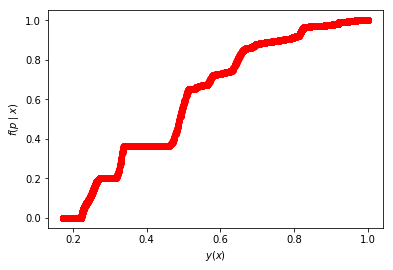

In [14]:
plt.plot(preds[target_test==1], poster, 'ro')
plt.ylabel('$f(p \mid x)$')
plt.xlabel('$y(x)$')

Analyze results:

In [15]:
# compute performance measures

realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                    data_test[target_test_true != 2].reshape(-1,))
realistic_poster[realistic_poster < 0] = 0

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], poster))
print('true MAE:',
      mean_absolute_error(realistic_poster, poster))
print('true RMSE:',
      np.sqrt(mean_squared_error(realistic_poster, poster)))

accuracy: 0.9349
ROC-AUC: 0.9696074933333334
brier: 0.05075425635487689
true MAE: 0.014880356443874972
true RMSE: 0.03472325825281474


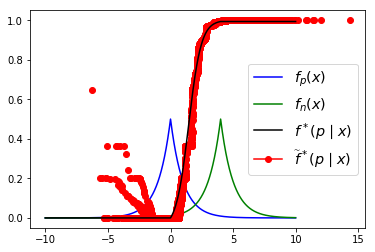

In [16]:
# illustrate performance graphically. The closer red circles to black line - the better.

plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0)
                                               for x in range(-1000, 1000)], 'k')

plt.legend(handles=(Line2D([], [], linestyle='-', color='b'),
                        Line2D([], [], linestyle='-', color='g'),
                        Line2D([], [], linestyle='-', color='k'),
                        Line2D([], [], color='r', marker='o')),
               labels=('$f_p(x)$', '$f_n(x)$', '$f^*(p \mid x)$', '$\widetilde{f}^*(p \mid x)$'),
          fontsize='x-large')

In [17]:
# # illustrate max_slope: argument of the highest point on the second graph is the estimate \alpha_n^*

# posters = []
# step = 0.005
# for test_alpha_ in np.arange(0, 1+step, step):
#     poster_ = 1 - diff * (1 - test_alpha_)
#     poster_[poster_ < 0] = 0
#     posters.append(np.mean(poster_) - test_alpha_)


# fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6, 10))
# axs[0].plot(np.arange(0, 1+step, step), posters)
# axs[1].plot(np.arange(2*step, 1+step, step), np.diff(np.diff(posters)))

### Inductive problem formulation

Suppose you also wanted to train a general classifier that not only labels the Unlabeled data set at hand but can also be applied to any new data in the future. In this case, what you need is NTC (either one of the classifiers trained during cross-validation or a new classifier trained on all the Unlabeled data), the mapping $r(y) = \frac{f_p(y)}{f_u(y)}$ from the NTC predictions to the density ratio, and the estimate of $\alpha^*$. The ratio r(y) is only estimated for a set of points from the unlabeled sample, rather than for all possible values $y \in [0, 1]$, so the estimates for unknown predictions $y(x)$ can simply be interpolated. Then, the pipeline is the following: apply NTC to any new data to obtain y(x), map it uisng interpolated r(y) to get the likelihood ratio, multiply the ratio by $\alpha^*$, clip in the $[0, 1]$ interval. Alternatively, map y(x) directly to clipped posteriors.

In [18]:
from inductive import InductiveDEDPUL

In [19]:
# train NTC

model = get_discriminator(data_test.shape[1], 1, 32, 1)
op = optim.Adam(model.parameters(), lr=1e-3)
train_NN(data_test[target_test==1], data_test[target_test==0], model, op,
         batch_size=65, n_epochs=100, n_batches=None, n_early_stop=10, disp=True)
pass

epoch 0 , train_loss= 0.70933
epoch 1 , train_loss= 0.60726
epoch 2 , train_loss= 0.54365
epoch 3 , train_loss= 0.50017
epoch 4 , train_loss= 0.47991
epoch 5 , train_loss= 0.44833
epoch 6 , train_loss= 0.42882
epoch 7 , train_loss= 0.43524
epoch 8 , train_loss= 0.42666
epoch 9 , train_loss= 0.43031
epoch 10 , train_loss= 0.42052
epoch 11 , train_loss= 0.4153
epoch 12 , train_loss= 0.43721
epoch 13 , train_loss= 0.42096
epoch 14 , train_loss= 0.40829
epoch 15 , train_loss= 0.40579
epoch 16 , train_loss= 0.41193
epoch 17 , train_loss= 0.41618
epoch 18 , train_loss= 0.38702
epoch 19 , train_loss= 0.38746
epoch 20 , train_loss= 0.4079
epoch 21 , train_loss= 0.42791
epoch 22 , train_loss= 0.39541
epoch 23 , train_loss= 0.40386
epoch 24 , train_loss= 0.39994
epoch 25 , train_loss= 0.4008
epoch 26 , train_loss= 0.43284
epoch 27 , train_loss= 0.41983
epoch 28 , train_loss= 0.40834
epoch 29 , train_loss= 0.42098
epoch 30 , train_loss= 0.39336
epoch 31 , train_loss= 0.40616
epoch 32 , train_loss

In [20]:
# map it directly to clipped posteriors.

ddpl = InductiveDEDPUL(model, preds[target_test == 1], poster)
# ddpl.predict(NTC_predictions_for_new_data)

# Other methods

# EN

EN is a common baseline to compare with.

Paper: https://cseweb.ucsd.edu/~elkan/posonly.pdf

In [31]:
EN_alpha, EN_poster = estimate_poster_en(preds, target_test, alpha=None, estimator='e3')

print('EN priors =', EN_alpha)
print('EN posters mean =', np.mean(EN_poster))
print()

EN_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], EN_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], EN_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], EN_poster.round()))
print('MAE:',
      mean_absolute_error(EN_realistic_poster, EN_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(EN_realistic_poster, EN_poster)))

EN priors = 0.7772898191028789
EN posters mean = 0.7822318219333996

accuracy: 0.9288
ROC-AUC: 0.9701842399999999
brier: 0.0712
MAE: 0.05460541901232714
RMSE: 0.11013102749541907


(0, 1)

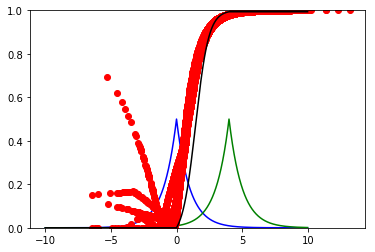

In [32]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2], EN_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# nnPU

nnPU is considered state-of-the-art (before DEDPUL). The method cannot identify the mixing proportions alpha and recquires them as a parameter. The method trains a neural network on unbiased risk function.

Paper: https://papers.nips.cc/paper/6765-positive-unlabeled-learning-with-non-negative-risk-estimator.pdf

In [44]:
nnre_poster = estimate_preds_cv(data_test, target_test, n_networks=1, cv=5, training_mode='nnre', alpha=cons_alpha,
                                n_hid_layers=0, lr=1e-3, bn=False, l2=1e-4,
                                train_nn_options={
                                    'n_epochs': 200, 'batch_size': 64, 'loss_function': 'sigmoid',
                                    'n_batches': None, 'n_early_stop': 20, 'disp': True})[target_test == 1]


nnre_realistic_poster = np.apply_along_axis(lambda x: (pm(x) - p1(x) * (1 - cons_alpha)) / pm(x), -1, 
                        data_test[target_test_true != 2].reshape(-1, ))

print('accuracy:', 
      accuracy_score(target_test_true[target_test_true != 2], nnre_poster.round()))
print('ROC-AUC:',
      roc_auc_score(target_test_true[target_test_true != 2], nnre_poster))
print('brier:',
      brier_score_loss(target_test_true[target_test_true != 2], nnre_poster.round()))
print('MAE:',
      mean_absolute_error(nnre_realistic_poster, nnre_poster))
print('RMSE:',
      np.sqrt(mean_squared_error(nnre_realistic_poster, nnre_poster)))

epoch 0 , train_loss= 0.44897 , test_loss= 0.16883
epoch 1 , train_loss= 0.36103 , test_loss= 0.12806
epoch 2 , train_loss= 0.30033 , test_loss= 0.11052
epoch 3 , train_loss= 0.26837 , test_loss= 0.1035
epoch 4 , train_loss= 0.23493 , test_loss= 0.09996
epoch 5 , train_loss= 0.20226 , test_loss= 0.09748
epoch 6 , train_loss= 0.18849 , test_loss= 0.09514
epoch 7 , train_loss= 0.16983 , test_loss= 0.09322
epoch 8 , train_loss= 0.17286 , test_loss= 0.09117
epoch 9 , train_loss= 0.17244 , test_loss= 0.08881
epoch 10 , train_loss= 0.18089 , test_loss= 0.08664
epoch 11 , train_loss= 0.12042 , test_loss= 0.08452
epoch 12 , train_loss= 0.12574 , test_loss= 0.08245
epoch 13 , train_loss= 0.11152 , test_loss= 0.08041
epoch 14 , train_loss= 0.13975 , test_loss= 0.07864
epoch 15 , train_loss= 0.12094 , test_loss= 0.07689
epoch 16 , train_loss= 0.12804 , test_loss= 0.07517
epoch 17 , train_loss= 0.11738 , test_loss= 0.07334
epoch 18 , train_loss= 0.10724 , test_loss= 0.07158
epoch 19 , train_loss= 

epoch 78 , train_loss= 0.09914 , test_loss= 0.05158
epoch 79 , train_loss= 0.07253 , test_loss= 0.05162
epoch 80 , train_loss= 0.09805 , test_loss= 0.05132
epoch 81 , train_loss= 0.07336 , test_loss= 0.05105
epoch 82 , train_loss= 0.05498 , test_loss= 0.05053
epoch 83 , train_loss= 0.07568 , test_loss= 0.05024
epoch 84 , train_loss= 0.05488 , test_loss= 0.05024
epoch 85 , train_loss= 0.08202 , test_loss= 0.05005
epoch 86 , train_loss= 0.07239 , test_loss= 0.04951
epoch 87 , train_loss= 0.07612 , test_loss= 0.04917
epoch 88 , train_loss= 0.04424 , test_loss= 0.04918
epoch 89 , train_loss= 0.05451 , test_loss= 0.04927
epoch 90 , train_loss= 0.05945 , test_loss= 0.04913
epoch 91 , train_loss= 0.09728 , test_loss= 0.04908
epoch 92 , train_loss= 0.08148 , test_loss= 0.0493
epoch 93 , train_loss= 0.06592 , test_loss= 0.04927
epoch 94 , train_loss= 0.08737 , test_loss= 0.04919
epoch 95 , train_loss= 0.07447 , test_loss= 0.04903
epoch 96 , train_loss= 0.07529 , test_loss= 0.04906
epoch 97 , tr

epoch 112 , train_loss= 0.08527 , test_loss= 0.03143
epoch 113 , train_loss= 0.06529 , test_loss= 0.03143
epoch 114 , train_loss= 0.07838 , test_loss= 0.03141
epoch 115 , train_loss= 0.04732 , test_loss= 0.03138
epoch 116 , train_loss= 0.0582 , test_loss= 0.03135
epoch 0 , train_loss= 0.28709 , test_loss= 0.11929
epoch 1 , train_loss= 0.25184 , test_loss= 0.11354
epoch 2 , train_loss= 0.22439 , test_loss= 0.11021
epoch 3 , train_loss= 0.21873 , test_loss= 0.10725
epoch 4 , train_loss= 0.2056 , test_loss= 0.10393
epoch 5 , train_loss= 0.20155 , test_loss= 0.10041
epoch 6 , train_loss= 0.11949 , test_loss= 0.09668
epoch 7 , train_loss= 0.16641 , test_loss= 0.09276
epoch 8 , train_loss= 0.16499 , test_loss= 0.08862
epoch 9 , train_loss= 0.12952 , test_loss= 0.08523
epoch 10 , train_loss= 0.13804 , test_loss= 0.08207
epoch 11 , train_loss= 0.11256 , test_loss= 0.07856
epoch 12 , train_loss= 0.13244 , test_loss= 0.07509
epoch 13 , train_loss= 0.10546 , test_loss= 0.07177
epoch 14 , train_lo

(0, 1)

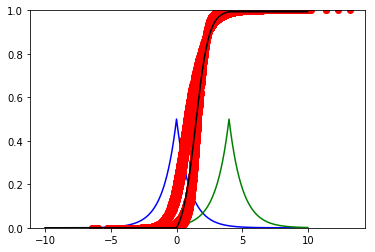

In [45]:
plt.plot([x/100 for x in range(-1000, 1000)], [p1(x/100) for x in range(-1000, 1000)], 'b')
plt.plot([x/100 for x in range(-1000, 1000)], [p2(x/100) for x in range(-1000, 1000)], 'g')
plt.plot(data_test[target_test_true != 2].flatten(), nnre_poster, 'ro')
plt.plot([x/100 for x in range(-1000, 1000)], [max((pm(x/100) - p1(x/100) * (1 - cons_alpha)) / pm(x/100), 0) 
                                               for x in range(-1000, 1000)], 'k')
plt.ylim(0, 1)

# Proportions Estimation

KM and TIcE are considered state-of-the-art in Mixture Proportion Estimation (before DEDPUL).

# KM 

Implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

Paper: https://arxiv.org/pdf/1603.02501.pdf

In [22]:
### KM is a very slow method

# KM_1, KM_2 = wrapper(mix_data_test, pos_data_test, epsilon=0.04, lambda_lower_bound=0.5, lambda_upper_bound=10, 
#                      KM_1=True, KM_2=True)
# KM_1 = 1 - KM_1
# KM_2 = 1 - KM_2

# print(KM_1)
# print(KM_2)
# print('KM_1:', KM_1, '\nKM_2:', KM_2, '\ncons_alpha:', cons_alpha, 
#       '\nerror KM_1:', abs(cons_alpha - KM_1), '\nerror KM_2:', abs(cons_alpha - KM_2))

# TIcE

Implementation is taken from https://dtai.cs.kuleuven.be/software/tice

Paper: https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewFile/16776/16539

In [53]:
from TIcE import tice_wrapper

In [54]:
tice_alpha = tice_wrapper(data_test, target_test, k=10, n_folds=10, delta=0.2, n_splits=40)
print('tice_alpha:', tice_alpha, '\ncons_alpha:', cons_alpha, '\nerror:', abs(cons_alpha - tice_alpha))

tice_alpha: 0.7169769849383337 
cons_alpha: 0.7362632708334493 
error: 0.019286285895115607
